In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [2]:
# set data paths
basepath = '/usr/bmicnas01/data-biwi-01/nkarani/students/nicolas/data/freiburg'

SUBJECT_DIRS = ['14/100190C4/100190C5',
 '17/1000310C/1000310D',
 '148/100000B2/100000B3',
 '31/10017A5B/10017A5C',
 '3/10000000/10000001',
 '68/1000319C/1000319D',
 '114/100068D6/100068D7',
 '33/1001789E/1001789F',
 '64/10003813/10003814',
 '7/10000423/10000424',
 '146/10000000/10000001',
 '34/100176D1/100176D2',
 '77/10000402/10000403',
 '76/10000675/10000676',
 '102/100002B8/100002B9',
 '74/10000AFC/10000AFD',
 '66/100034EF/100034F0',
 '15/10018F01/10018F02',
 '120/100002BE/100002BF',
 '139/10006F20/10006F21',
 '24/100183C6/100183C7',
 '52/10016105/10016106',
 '35/10017524/10017525',
 '95/1000050D/1000050E',
 '65/10003682/10003683',
 '14/10002CA3/10002CA4',
 '94/10000718/10000719',
 '46/1001680B/1001680C',
 '30/10017BB2/10017BB3',
 '26/100180D1/100180D2']

Subject: 14/100190C4/100190C5
Image shape: (160, 120, 30, 40, 4)
================= Intensity statistics =================
min: 0
max: 340
mean: 43.46871427951389
median: 36.0
5th percentile: 4.0
95th percentile: 123.0
================= vx statistics =================
min: 0
max: 4096
mean: 2031.582618185764
median: 2048.0
5th percentile: 1594.0
95th percentile: 2343.0
================= vy statistics =================
min: 0
max: 4096
mean: 2010.2903064670138
median: 2030.0
5th percentile: 1507.0
95th percentile: 2356.0
================= vz statistics =================
min: 0
max: 4096
mean: 2025.435356640625
median: 2039.0
5th percentile: 1500.0
95th percentile: 2441.0


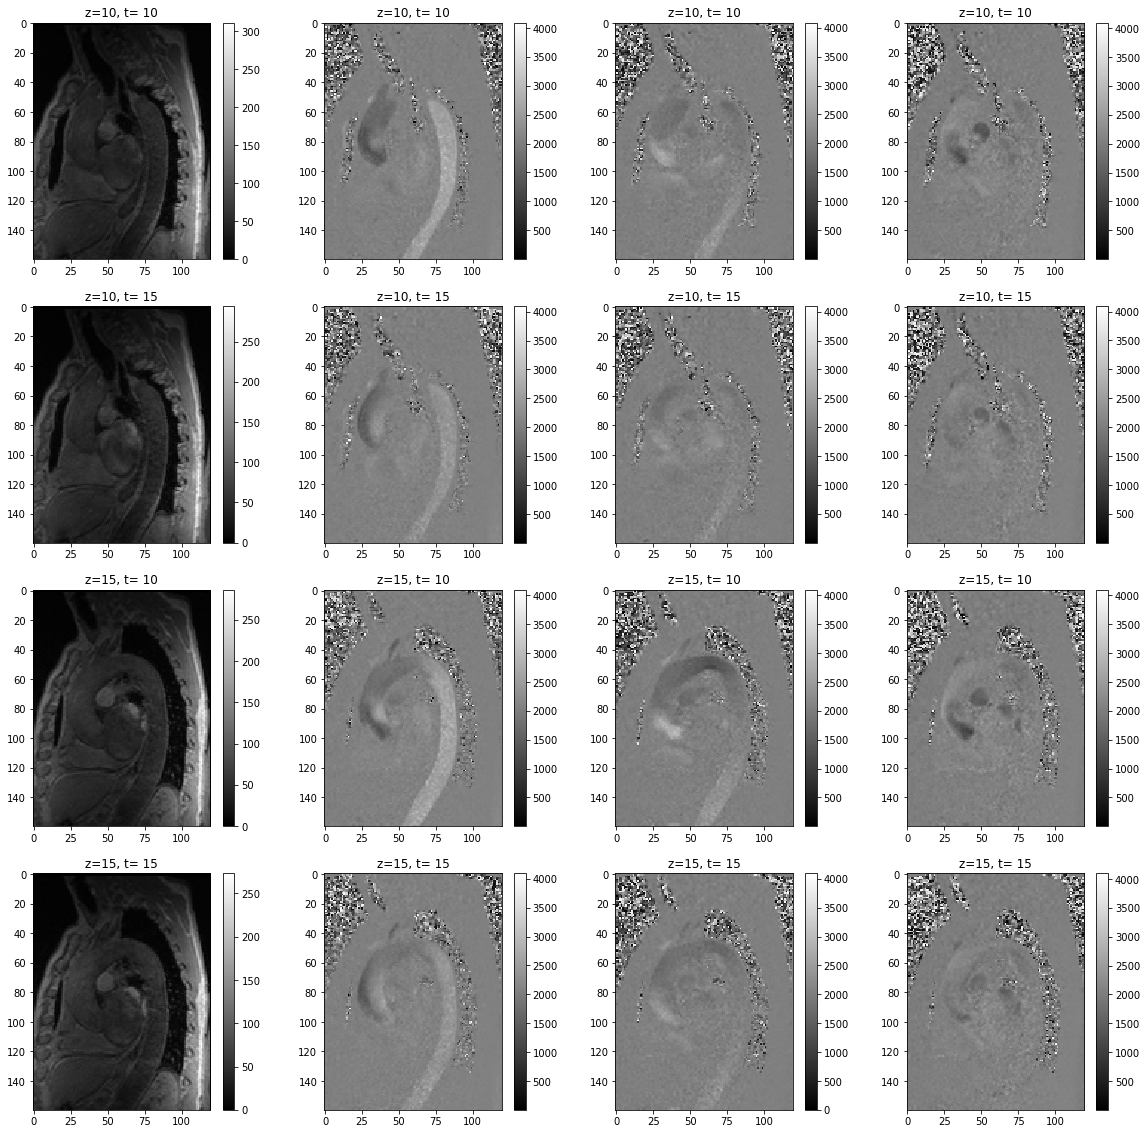

In [3]:
# read an image for 1 subject
SUBJECT_NUM = 0

# load the numpy image (saved by the dicom2numpy file)
image_data = np.load(basepath + '/' + SUBJECT_DIRS[SUBJECT_NUM] + '/image.npy')  

# print some details about the image
print('Subject: ' + SUBJECT_DIRS[SUBJECT_NUM])
print('Image shape: ' + str(image_data.shape))

def print_stats(arr):
    print('min: ' + str(np.min(arr)))
    print('max: ' + str(np.max(arr)))
    print('mean: ' + str(np.mean(arr)))
    print('median: ' + str(np.median(arr)))
    print('5th percentile: ' + str(np.percentile(arr, 5)))
    print('95th percentile: ' + str(np.percentile(arr, 95)))
        
print('================= Intensity statistics =================')
print_stats(image_data[..., 0])

print('================= vx statistics =================')
print_stats(image_data[..., 1])

print('================= vy statistics =================')
print_stats(image_data[..., 2])

print('================= vz statistics =================')
print_stats(image_data[..., 3])

# visualize the original image
def visualize_image(image,
                    z1 = 10, z2 = 10, z3 = 15, z4 = 15,
                    t1 = 10, t2 = 15, t3 = 10, t4 = 15):    
    
    plt.figure(figsize=[20,20])
    for i in range(4):
        plt.subplot(4, 4, i+1)
        plt.imshow(image[:, :, z1, t1, i], cmap='gray')
        plt.colorbar()
        plt.title('z=' + str(z1) + ', t= ' + str(t1))
    for i in range(4):
        plt.subplot(4, 4, i+5)
        plt.imshow(image[:, :, z2, t2, i], cmap='gray')
        plt.colorbar()
        plt.title('z=' + str(z2) + ', t= ' + str(t2))
    for i in range(4):
        plt.subplot(4, 4, i+9)
        plt.imshow(image[:, :, z3, t3, i], cmap='gray')
        plt.colorbar()
        plt.title('z=' + str(z3) + ', t= ' + str(t3))
    for i in range(4):
        plt.subplot(4, 4, i+13)
        plt.imshow(image[:, :, z4, t4, i], cmap='gray')
        plt.colorbar()
        plt.title('z=' + str(z4) + ', t= ' + str(t4))
    plt.show()
    
visualize_image(image_data)

## ======================================
# All velocity values in the original images are positive. 
# It seems that 2048 (around the median value for multiple subjects, in all 3 directions), corresponds to zero velocity, with higher and lower values indicating positive and negative flow respectively.

# Also, the 5th and 95th percentiles are pretty far off the min and max values - this indicates the presence of outliers. It would be better to ignore these outliers during normalization.
# ======================================

In [4]:
# ==========================================       
# function to normalize the input arrays (intensity and velocity) to a range between 0 to 1.
# magnitude normalization is a simple division by the largest value.
# velocity normalization first calculates the largest magnitude velocity vector
# and then scales down all velocity vectors with the magnitude of this vector.
# ==========================================        
def normalize_image_strategy1(image):

    # ===============    
    # initialize with zeros
    # ===============
    normalized_image = np.zeros((image.shape))
    
    # ===============
    # normalize magnitude channel
    # ===============
    normalized_image[...,0] = image[...,0] / np.amax(image[...,0])
    
    # ===============
    # normalize velocities
    # ===============
    
    # extract the velocities in the 3 directions
    velocity_image = np.array(image[...,1:4])
    
    # denoise the velocity vectors
    velocity_image_denoised = gaussian_filter(velocity_image, 0.5)
    
    # compute per-pixel velocity magnitude    
    velocity_mag_image = np.linalg.norm(velocity_image_denoised, axis=-1)
    
    # velocity_mag_array = np.sqrt(np.square(velocity_arrays[...,0])+np.square(velocity_arrays[...,1])+np.square(velocity_arrays[...,2]))
    # find max value of 95th percentile (to minimize effect of outliers) of magnitude array and its index
    vpercentile = np.percentile(velocity_mag_image, 95)    
    normalized_image[...,1] = velocity_image_denoised[...,0] / vpercentile
    normalized_image[...,2] = velocity_image_denoised[...,1] / vpercentile
    normalized_image[...,3] = velocity_image_denoised[...,2] / vpercentile  
    
    # print('normalized arrays: max=' + str(np.amax(normalized_arrays)) + ' min:' + str(np.amin(normalized_arrays)))
  
    return normalized_image

# ==========================================
# 
# ==========================================
def normalize_image_strategy2(image):

    # ===============
    # initialize with zeros
    # ===============
    normalized_image = np.zeros((image.shape))

    # ===============
    # normalize magnitude channel
    # ===============
    normalized_image[...,0] = image[...,0] / np.amax(image[...,0])

    # ===============
    # normalize velocities
    # ===============

    # extract the velocities in the 3 directions
    velocity_image = np.array(image[...,1:4])

    # denoise the velocity vectors
    velocity_image_denoised = gaussian_filter(velocity_image, 0.5)

    # compute per-pixel velocity magnitude
    velocity_mag_image = np.linalg.norm(velocity_image_denoised, axis=-1)

    # velocity_mag_array = np.sqrt(np.square(velocity_arrays[...,0])+np.square(velocity_arrays[...,1])+np.square(velocity_arrays[...,2]))
    # find max value of 95th percentile (to minimize effect of outliers) of magnitude array and its index
    #vpercentile_min = np.percentile(velocity_mag_image, 5)
    #vpercentile_max = np.percentile(velocity_mag_image, 95)

    normalized_image[...,1] = 2.*(velocity_image_denoised[...,0] - np.min(velocity_image_denoised))/ np.ptp(velocity_image_denoised)-1
    normalized_image[...,2] = 2.*(velocity_image_denoised[...,1] - np.min(velocity_image_denoised))/ np.ptp(velocity_image_denoised)-1
    normalized_image[...,3] = 2.*(velocity_image_denoised[...,2] - np.min(velocity_image_denoised))/ np.ptp(velocity_image_denoised)-1

    # normalized = 2.*(velocity_image_denoised - np.min(velocity_image_denoised))/np.ptp(velocity_image_denoised)-1
    # print('normalized arrays: max=' + str(np.amax(normalized_arrays)) + ' min:' + str(np.amin(normalized_arrays)))

    return normalized_image

================= Intensity statistics =================
min: 0.0
max: 1.0
mean: 0.12784915964562932
median: 0.10588235294117647
5th percentile: 0.011764705882352941
95th percentile: 0.36176470588235293
================= vx statistics =================
min: 0.13736505611963715
max: 0.9141697727031666
mean: 0.5395623365220823
median: 0.5438697861480982
5th percentile: 0.46400638142737893
95th percentile: 0.5864636019991485
================= vy statistics =================
min: 0.1458838192898472
max: 0.9048523754857493
mean: 0.5355349352617083
median: 0.5401428272611313
5th percentile: 0.45921457714413577
95th percentile: 0.5824704317631125
================= vz statistics =================
min: 0.12006131843014796
max: 0.9556987431579406
mean: 0.5381016474323861
median: 0.5414738840064767
5th percentile: 0.45814973174785956
95th percentile: 0.596579633263773


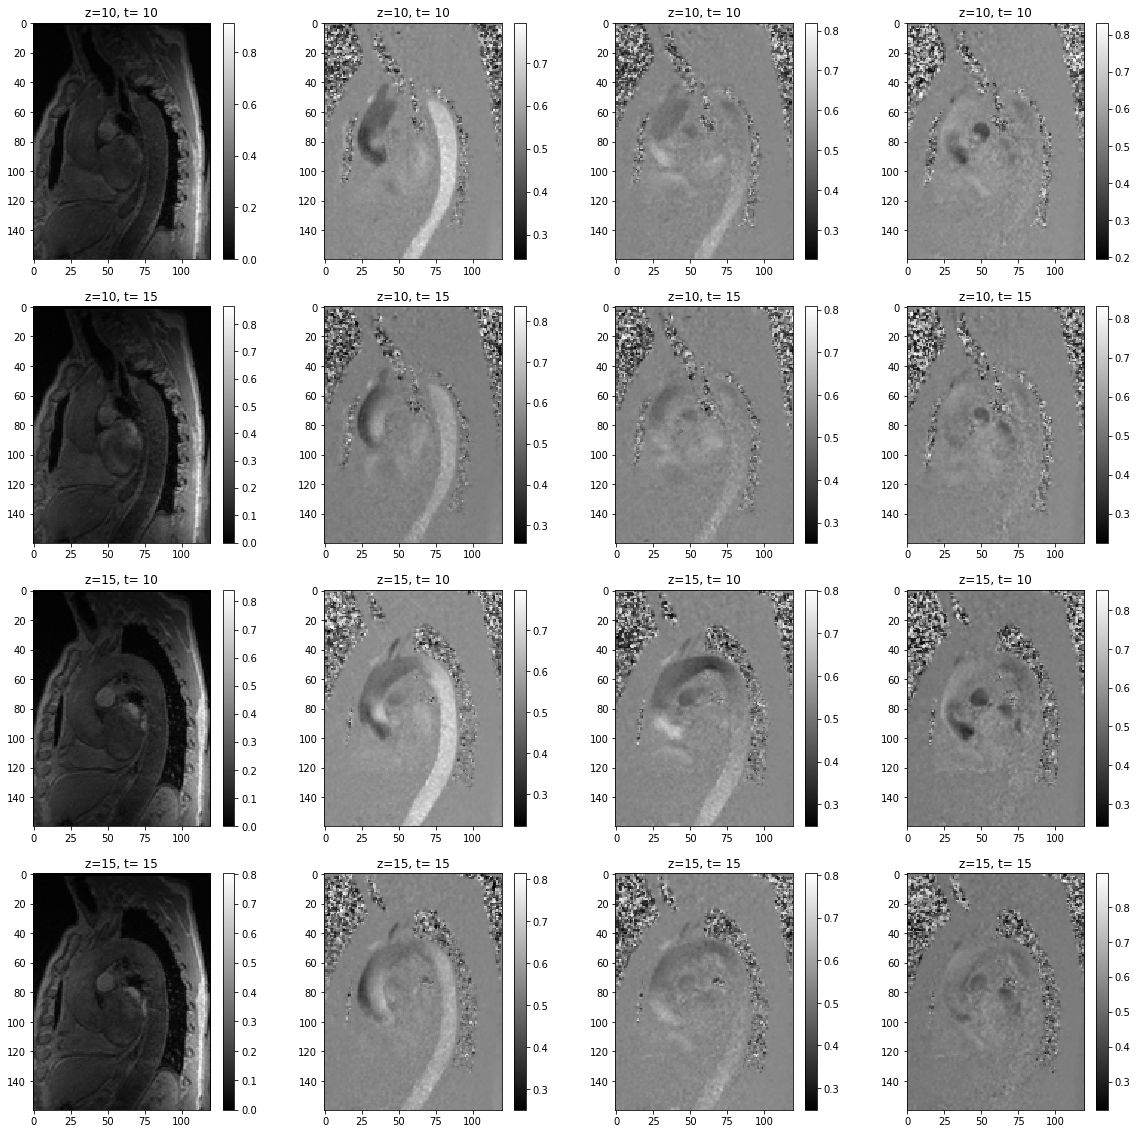

In [5]:
# normalize the image using strategy 1
image_data_normalized_strategy1 = normalize_image_strategy1(image_data)

print('================= Intensity statistics =================')
print_stats(image_data_normalized_strategy1[..., 0])

print('================= vx statistics =================')
print_stats(image_data_normalized_strategy1[..., 1])

print('================= vy statistics =================')
print_stats(image_data_normalized_strategy1[..., 2])

print('================= vz statistics =================')
print_stats(image_data_normalized_strategy1[..., 3])

visualize_image(image_data_normalized_strategy1)

================= Intensity statistics =================
min: 0.0
max: 1.0
mean: 0.12784915964562932
median: 0.10588235294117647
5th percentile: 0.011764705882352941
95th percentile: 0.36176470588235293
================= vx statistics =================
min: -0.9585855367951577
max: 0.9006052883083784
mean: 0.004026401111907548
median: 0.014335775724753086
5th percentile: -0.17680790060528828
95th percentile: 0.11627906976744184
================= vy statistics =================
min: -0.93819687798662
max: 0.8783051927365404
mean: -0.005612710639667624
median: 0.0054157374960177584
5th percentile: -0.18827652118509075
95th percentile: 0.10672188595093979
================= vz statistics =================
min: -1.0
max: 1.0
mean: 0.0005304133869154857
median: 0.008601465434851852
5th percentile: -0.190825103536158
95th percentile: 0.14049060210258046


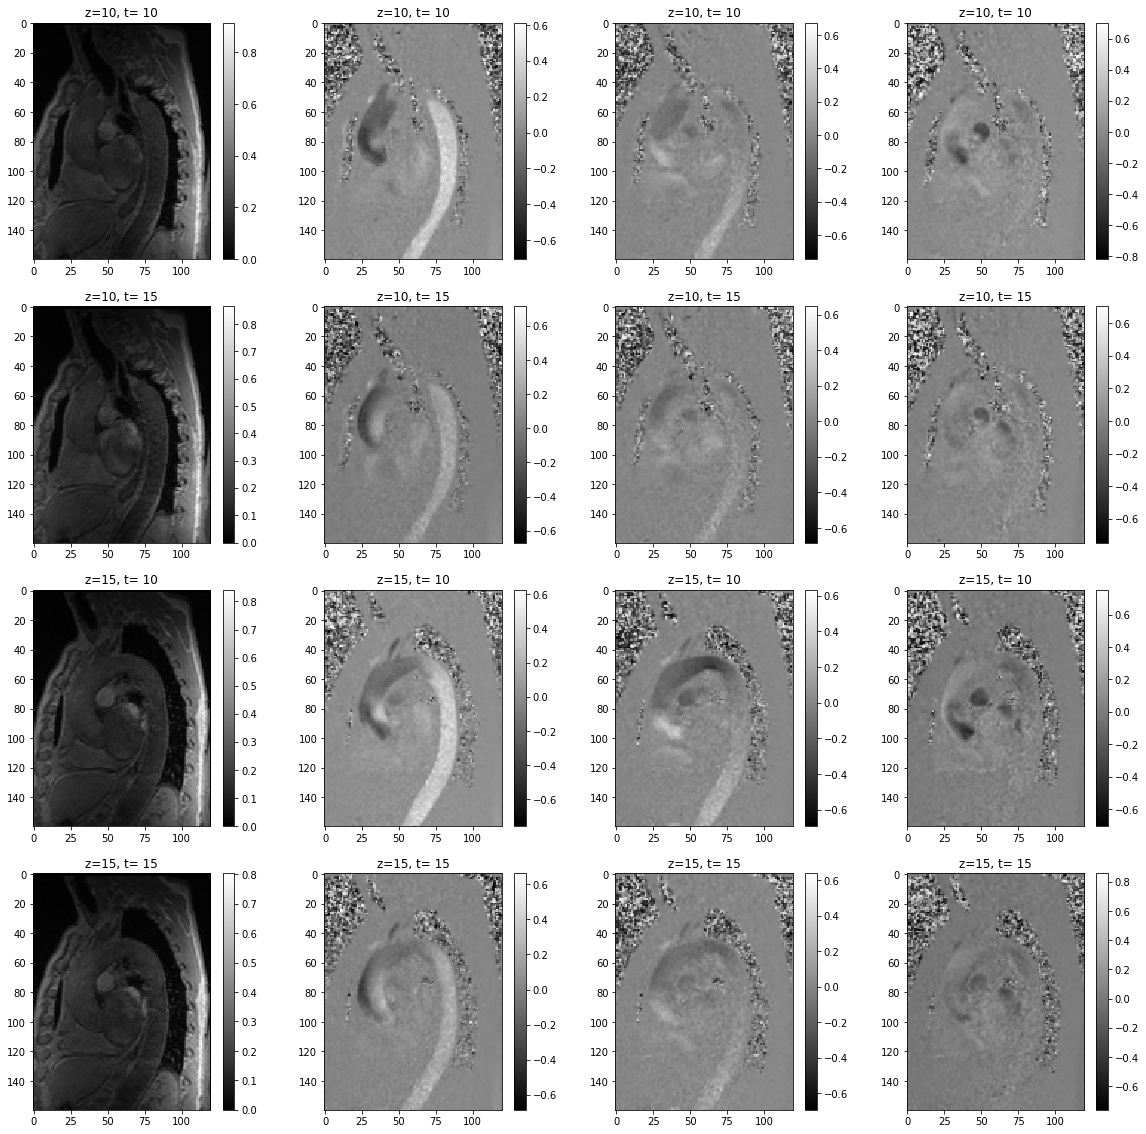

In [6]:
# normalize the image using strategy 2
image_data_normalized_strategy2 = normalize_image_strategy2(image_data)

print('================= Intensity statistics =================')
print_stats(image_data_normalized_strategy2[..., 0])

print('================= vx statistics =================')
print_stats(image_data_normalized_strategy2[..., 1])

print('================= vy statistics =================')
print_stats(image_data_normalized_strategy2[..., 2])

print('================= vz statistics =================')
print_stats(image_data_normalized_strategy2[..., 3])

visualize_image(image_data_normalized_strategy2)